In [94]:
import sys,os
import cv2
import numpy as np
import xarray as xr
import pandas as pd
from tqdm.notebook import tqdm
import pickle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import utils as ut


print(cv2.__version__)

4.5.3


In [40]:
TILE_FILENAME_FORMAT = "{triplet_id:05d}_{tile_type}.png"

TEST_SIZE    = 0.3
RANDOM_STATE = 1024
COLORS = ['b', 'g', 'r', 'm'] # Color of each class

# Path data of the original images
DATASETS_path = "/home/fbrient/Dropbox/Documents/EUREC4A/Data/"
DATASET_DIR   = DATASETS_path+"Kaggle/"

#In order to reduce the submission file size, our metric uses run-length encoding on the pixel values.
#Instead of submitting an exhaustive list of indices for your segmentation, you will submit pairs of values
#that contain a start position and a run length. 
#E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3).

#The competition format requires a space delimited list of pairs. 
#For example, '1 3 10 5' implies pixels 1,2,3,10,11,12,13,14 are to be included in the mask. 
#The metric checks that the pairs are sorted, positive, and the decoded pixel values are not duplicated. 
# The pixels are numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.





In [3]:
# Read encoded pixels of labels
df = pd.read_csv(DATASET_DIR+"train.csv")
print(df.head())
print(type(df))

          Image_Label                                      EncodedPixels
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...
2  0011165.jpg_Gravel                                                NaN
3   0011165.jpg_Sugar                                                NaN
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...
<class 'pandas.core.frame.DataFrame'>


In [4]:
# Clean information listed in the the DataFrame
df['Image'] = df['Image_Label'].map(lambda x: x.split('_')[0])
df['Class'] = df['Image_Label'].map(lambda x: x.split('_')[1])
classes     = df['Class'].unique()
train_df    = df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    df[class_name] = df['Class'].map(lambda x: 1 if class_name in x else 0)
df.head()

Image_Label                                      EncodedPixels  \
0    0011165.jpg_Fish  264918 937 266318 937 267718 937 269118 937 27...   
1  0011165.jpg_Flower  1355565 1002 1356965 1002 1358365 1002 1359765...   
2  0011165.jpg_Gravel                                                NaN   
3   0011165.jpg_Sugar                                                NaN   
4    002be4f.jpg_Fish  233813 878 235213 878 236613 878 238010 881 23...   

         Image   Class  Fish  Flower  Gravel  Sugar  
0  0011165.jpg    Fish     1       0       0      0  
1  0011165.jpg  Flower     0       1       0      0  
2  0011165.jpg  Gravel     0       0       1      0  
3  0011165.jpg   Sugar     0       0       0      1  
4  002be4f.jpg    Fish     1       0       0      0

In [5]:
# Creating training samples

# List of files
image_col   = np.array(df['Image'])
image_files = image_col[::4]

all_labels  = df['Class']

# List of images with label 
X_train, y_train  = image_files, all_labels
train_pairs       = np.array(list(zip(X_train, y_train)))
NUM_TRAIN_SAMPLES = len(train_pairs)
print(NUM_TRAIN_SAMPLES) #5546

# Randomize the train_pairs array
train_samples = train_pairs[np.random.choice(train_pairs.shape[0], NUM_TRAIN_SAMPLES, replace=False), :]


5546


  0%|          | 0/5546 [00:00<?, ?it/s]

              Image_Label                                      EncodedPixels  \
18576    d74517a.jpg_Fish  22203 196 23603 196 25003 196 26403 196 27803 ...   
18577  d74517a.jpg_Flower                                                NaN   
18578  d74517a.jpg_Gravel                                                NaN   
18579   d74517a.jpg_Sugar  59347 253 60747 253 62147 253 63547 253 64947 ...   

             Image   Class  Fish  Flower  Gravel  Sugar  
18576  d74517a.jpg    Fish     1       0       0      0  
18577  d74517a.jpg  Flower     0       1       0      0  
18578  d74517a.jpg  Gravel     0       0       1      0  
18579  d74517a.jpg   Sugar     0       0       0      1  
d74517a.jpg
0 (349, 785, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (410, 879, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768


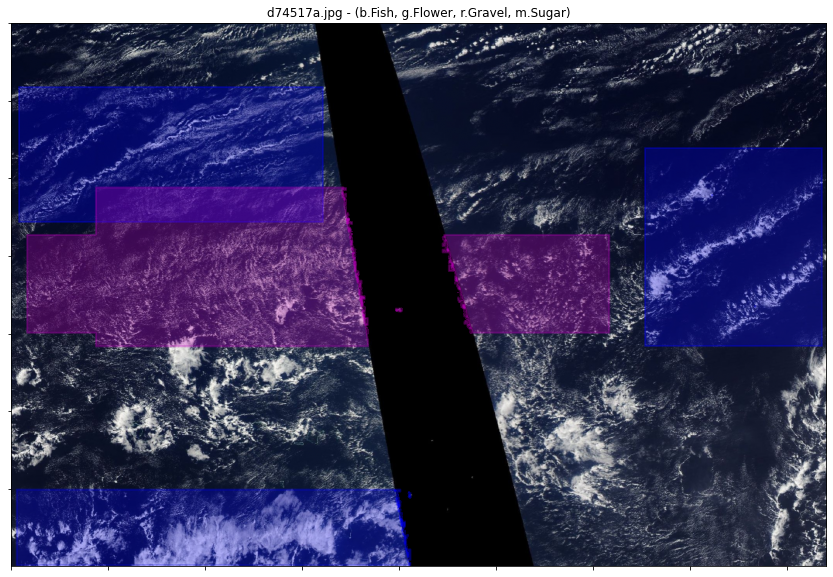

fd1610d.jpg
3 (410, 406, 3)
0 0
0 256
256 0
256 256
88f3fe7.jpg
1 (1328, 383, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
1024 0
1024 256
1280 0
1280 256
2 (581, 1098, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
0bb16fb.jpg
1 (908, 1105, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (1137, 684, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
6255e8f.jpg
0 (670, 574, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
1 (490, 656, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (379, 727, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (948, 537, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
4352c3a.jpg
0 (883, 1101, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512

1 (434, 732, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (688, 444, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (213, 1341, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
ac0020d.jpg
1 (866, 2097, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
768 2048
3 (963, 1543, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
4d8f632.jpg
0 (374, 1064, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (687, 371, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (328, 754, 3)
0 0
0 256
0 512
256 0
256 256
256 512
ec4c19d.jpg
1 (1090, 814, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 2

0 (523, 1592, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
1 (745, 986, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (557, 1048, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
80dcbbd.jpg
2 (1212, 1010, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (266, 649, 3)
0 0
0 256
0 512
256 0
256 256
256 512
f5691a9.jpg
2 (1400, 1756, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 

256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (800, 486, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
2228713.jpg
1 (938, 1542, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
2 (685, 781, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (1290, 781, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
5291a8b.jpg
0 (423, 984, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
0fa3287.jpg
1 (511, 988, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (369, 637, 3)
0 0
0 256
0 512
256 0
256 256
256 512
8bacf39.jpg
2 (837, 1152, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256

2 (559, 364, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (981, 732, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
eb24ca3.jpg
0 (606, 605, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
1 (901, 1194, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (432, 698, 3)
0 0
0 256
0 512
256 0
256 256
256 512
7e820d6.jpg
1 (542, 637, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
ec8c63f.jpg
0 (794, 1536, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (605, 740, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (691, 1476, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
78b51ec.jpg
0 (715, 1

1 (810, 983, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
b27759f.jpg
2 (499, 611, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (1225, 836, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
a84c738.jpg
0 (933, 1432, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
e2ae924.jpg
1 (633, 835, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (1261, 858, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (817, 1141, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 102

0 (880, 642, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
2 (741, 688, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (1250, 1353, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
51188da.jpg
0 (571, 2079, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
2 (965, 629, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (298, 861, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
94667e6.jpg
0 (433, 1476, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
3 (366, 656, 3)
0 0
0 256
0 512
256 0
256 256
256 512
5283d

2 (1188, 1488, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
9519c5c.jpg
0 (1130, 976, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1 (1157, 827, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
2 (578, 767, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
8bf3d51.jpg
3 (587, 364, 3)
0 0
0 256
256 0
256 256
512 0
512 256
fb53793.jpg
0 (776, 438, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
1 (710, 875, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
d9dd36e.jpg
0 (984, 1352, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256

0 (962, 1275, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1 (431, 1013, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (286, 511, 3)
0 0
0 256
256 0
256 256
30fc15d.jpg
0 (430, 1080, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (320, 1235, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (227, 695, 3)
0 0
0 256
0 512
04d5fe8.jpg
0 (1080, 673, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
2 (870, 436, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
7baef0c.jpg
1 (1074, 939, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (991, 701, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1eac7c5.jpg
1 (619, 1135, 3)
0 0
0 25

256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
b60ca64.jpg
0 (612, 1106, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (677, 1330, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
e1cc002.jpg
2 (539, 827, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (708, 1067, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
296af3d.jpg
3 (726, 1206, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
bc12ca1.jpg
0 (586, 921, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (449, 462, 3)
0 0
0 256
256 0
256 256
2 (1195, 1352, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 7

1 (1253, 929, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (1044, 675, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
7a00b78.jpg
2 (542, 916, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (588, 1002, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
5ef9368.jpg
2 (663, 996, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (528, 821, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3dac0d2.jpg
2 (987, 1231, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (695, 781, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
638a4e0.jpg
0 (1169, 15

0 (635, 779, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (1264, 1348, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
3 (467, 662, 3)
0 0
0 256
0 512
256 0
256 256
256 512
4f98285.jpg
0 (690, 1014, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (1399, 1860, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
5033c51.jpg
0 (673, 837, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512

0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
028fd83.jpg
2 (1384, 1195, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
3 (819, 446, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
4d19d32.jpg
3 (391, 697, 3)
0 0
0 256
0 512
256 0
256 256
256 512
484846a.jpg
0 (411, 1054, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
a353a1c.jpg
0 (447, 1317, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
2 (684, 1041, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (884, 1525, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 76

0 (1338, 2095, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
768 2048
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1024 2048
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
1280 2048
3 (250, 928, 3)
0 0
0 256
0 512
0 768
031bfc5.jpg
0 (809, 888, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (428, 966, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (702, 1353, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
ddd5983.jpg
0 (304, 423, 3)
0 0
0 256
256 0
256 256
2 (282, 1024, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (850, 1319, 3)

0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
2 (833, 1012, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
a1afacf.jpg
0 (405, 699, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (628, 374, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (306, 360, 3)
0 0
0 256
256 0
256 256
3 (780, 890, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
fafc316.jpg
1 (886, 1241, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (339, 310, 3)
0 0
0 256
256 0
256 256
1e81237.jpg
0 (844, 1988, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
2

1 (844, 459, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
2 (1395, 1309, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
60bac00.jpg
2 (490, 439, 3)
0 0
0 256
256 0
256 256
e8d414f.jpg
0 (358, 641, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (914, 1021, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (499, 754, 3)
0 0
0 256
0 512
256 0
256 256
256 512
d81b38d.jpg
0 (1210, 1649, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
3 (864, 801, 3)
0

1 (900, 1075, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (469, 728, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (509, 985, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
f128b90.jpg
0 (459, 794, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
1 (1399, 1192, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (664, 457, 3)
0 0
0 256
256 0
256 256
512 0
512 256
573e737.jpg
3 (458, 481, 3)
0 0
0 256
256 0
256 256
d9433e5.jpg
0 (715, 1318, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (925, 1816, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
2

3 (897, 602, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
d92fd9b.jpg
0 (752, 1267, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (472, 1209, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (1123, 601, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
3 (470, 497, 3)
0 0
0 256
256 0
256 256
309fa70.jpg
1 (1362, 1193, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
3 (1255, 892, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
f55bc0a.jpg
0 (438, 1068, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
25

0 (349, 1242, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (699, 1660, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
7ca7d72.jpg
0 (1390, 1689, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
73c24cd.jpg
0 (502, 1005, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
30a242e.jpg
1 (841, 1708, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
4623c6c.jpg
3 (601, 1207, 3)
0 0
0 256
0 512


0 (793, 526, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (546, 1018, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
b30a770.jpg
1 (1400, 1164, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (444, 502, 3)
0 0
0 256
256 0
256 256
3 (738, 475, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3e088fa.jpg
3 (1082, 891, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
6ffe24a.jpg
2 (243, 792, 3)
0 0
0 256
0 512
0 768
3 (840, 881, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
07c5a0d.jpg
0 (1139, 1419, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 

0 (733, 1510, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (432, 1286, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
2 (364, 719, 3)
0 0
0 256
0 512
256 0
256 256
256 512
ab98b1b.jpg
0 (503, 413, 3)
0 0
0 256
256 0
256 256
1 (419, 1047, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
d519943.jpg
0 (424, 1144, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3c61c1f.jpg
1 (947, 795, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (678, 446, 3)
0 0
0 256
256 0
256 256
512 0
512 256
10f21b7.jpg
3 (593, 1480, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
c651b18.jpg
3 (928, 1727, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1

0 (616, 1364, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (589, 1032, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (421, 292, 3)
0 0
0 256
256 0
256 256
5c222e1.jpg
0 (641, 1271, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (1108, 1304, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
3 (728, 823, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
dfdad36.jpg
1 (415, 1021, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (337, 642, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3b0f693.jpg
2 (769, 712, 3)
0 0
0 256
0 512
256 0
256 256
256 512


2 (1030, 1864, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
3 (1377, 547, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
1280 0
1280 256
1280 512
c0b77e6.jpg
2 (733, 997, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
eaa2a7f.jpg
0 (569, 710, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2 (854, 706, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
319c0d9.jpg
3 (529, 925, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
80ccadc.jpg
0 (518, 372, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (636, 740, 3)
0 0
0 256
0 512
256 0
2

0 (816, 1707, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1 (1399, 1906, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
2 (337, 654, 3)
0 0
0 256
0 512
256 0
256 256
256 512
d3dfa34.jpg
0 (487, 1408, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
afd3da4.jpg
2 (599, 1070, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
84a294c.jpg
0 (296, 1196, 3)
0 0
0 256
0 512
0 768
0

0 (747, 882, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (891, 803, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (1094, 731, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
3 (336, 399, 3)
0 0
0 256
256 0
256 256
3d7bf44.jpg
0 (720, 1705, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
3 (686, 1553, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
5aa9ef7.jpg
0 (458, 554, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (1237, 1471, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 

2 (994, 1303, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (440, 651, 3)
0 0
0 256
0 512
256 0
256 256
256 512
f800872.jpg
1 (1278, 974, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
2 (605, 986, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
faa64f6.jpg
0 (345, 1154, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (990, 1291, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
4fed565.jpg
2 (1177, 770, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
a9c7fd3

0 (733, 1184, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (313, 836, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (968, 731, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1a89fcf.jpg
1 (613, 575, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (935, 998, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
7bfbcac.jpg
0 (451, 750, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (369, 587, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (754, 932, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (659, 1957, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
f0b92a9.jpg
1 (486, 1117, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 5

1 (1166, 1219, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
c6d834b.jpg
0 (282, 582, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (666, 954, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (314, 536, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (783, 502, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
f2bc927.jpg
0 (370, 541, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (718, 471, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (1106, 955, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
fac69d0.jpg
1 (912, 900, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (438, 473, 3)
0 0
0 256
256 0
256 256
72c0d05.jpg
1 (981, 701, 3)
0 0
0 256
0 512

0 (971, 732, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
2 (815, 851, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (376, 1223, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
454cd29.jpg
0 (547, 579, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
1 (1249, 894, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
2 (820, 764, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (585, 941, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
ebd7bef.jpg
1 (1036, 1259, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
8d68de6.jpg
0 (941, 94

3 (393, 824, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
169a970.jpg
2 (831, 2011, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
3 (208, 1515, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
b8ffe62.jpg
2 (1385, 1636, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (317, 1576, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
0ac087b.jpg
2 (1374, 1067, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
5

3 (660, 1282, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2581372.jpg
1 (1032, 958, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (1096, 876, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
cc841a2.jpg
0 (529, 627, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
1 (703, 1145, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
0187cd7.jpg
1 (1282, 748, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
1280 0
1280 256
1280 512
2 (330, 975, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (548, 1003, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512

3 (1100, 1030, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
b3cc504.jpg
3 (895, 630, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
6ee8ff5.jpg
1 (1327, 986, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
16c65fc.jpg
2 (951, 954, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (531, 1120, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
f509757.jpg
0 (728, 532, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2 (600, 700, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
80ec093.jpg
0 (451, 1440, 3)
0 0
0 256
0 512


0 (849, 1987, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
aacfb6a.jpg
0 (1323, 1100, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
1 (365, 568, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (471, 280, 3)
0 0
0 256
256 0
256 256
a7e5fa4.jpg
0 (955, 1172, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (760, 1548, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
1db9078.jpg
0 (432, 1628, 3)

1 (977, 1062, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
d00fef2.jpg
3 (1124, 693, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
5c07f2e.jpg
1 (593, 1255, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (721, 815, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
181395a.jpg
0 (612, 1301, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (110, 839, 3)
0 0
0 256
0 512
0 768
3 (691, 1434, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
3c4decc.jpg
1 (1128, 1452, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0

0 (419, 1025, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (977, 1159, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
4be905a.jpg
1 (598, 898, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (801, 1571, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
892ccf7.jpg
0 (1025, 1164, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
3 (665, 810, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
a3e83f6.jpg
0 (539, 890, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256

0 (643, 315, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (563, 906, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (1167, 1032, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1b943b9.jpg
0 (1329, 1192, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (1192, 528, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
3 (1337, 576, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
1280 0
1280 256
1280 512
26ca2e3.jpg
3 (368, 352, 3)
0 0
0 256
256 0
256 256
ed3c46c.jpg
0 (646, 1075, 3)
0 0
0 256
0 512
0 768


0 (542, 1489, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (700, 846, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
b90ed50.jpg
0 (627, 515, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (779, 1293, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
f829a0a.jpg
0 (344, 609, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (972, 1598, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
50b4510.jpg
2 (877, 699, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (911, 741, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
5

0 (309, 1109, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (1054, 730, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
3 (585, 579, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2882cd5.jpg
3 (1280, 1560, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
042bba1.jpg
0 (732, 1292, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (499, 451, 3)
0 0
0 256
256 0
256 256
3 (1126, 971, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
c490423.jpg
2 (1053, 1512, 3)
0 0
0 256
0 5

3 (463, 1666, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
1efdd45.jpg
0 (408, 1295, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
2 (459, 1015, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (759, 908, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
48c64fb.jpg
1 (932, 966, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (1390, 1360, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
a25f60a.jpg
0 (928, 1309, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1

2 (777, 1076, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (551, 1032, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
c62eadf.jpg
3 (853, 851, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
5e70931.jpg
0 (851, 780, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (333, 689, 3)
0 0
0 256
0 512
256 0
256 256
256 512
20019f4.jpg
0 (872, 811, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (1177, 570, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
3 (423, 824, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
f14772a.jpg
0 (1120, 1596, 3)
0 0
0 256
0 512
0

256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
64f2d80.jpg
1 (1377, 1124, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (380, 632, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (1390, 583, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
1280 0
1280 256
1280 512
046586a.jpg
3 (511, 948, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
0a1b596.jpg
2 (399, 707, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (319, 551, 3)
0 0
0 256
0 512
256 0
256 256
256 512
25fbe3c.jpg
2 (729, 830, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (1234, 1671, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
2

0 (701, 1303, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (1397, 1488, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
3 (516, 1365, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
0a14f2b.jpg
0 (1358, 934, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
2 (685, 409, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (900, 613, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
be1c45f.jpg
0 (949, 1319, 3)
0 0
0 

0 (1389, 1392, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
2 (898, 472, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
3 (466, 524, 3)
0 0
0 256
0 512
256 0
256 256
256 512
e0cbf7e.jpg
0 (821, 1280, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (1373, 1706, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (531, 1103, 3)
0 0
0 256
0 512
0 76

256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
2 (494, 512, 3)
0 0
0 256
256 0
256 256
3 (371, 702, 3)
0 0
0 256
0 512
256 0
256 256
256 512
7a00976.jpg
0 (1368, 1254, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (379, 795, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (306, 1141, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
994e66f.jpg
1 (683, 1315, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
3 (360, 576, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1d6d628.jpg
0 (437, 716, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (706, 469, 3)
0 0
0 256
256 0
256 256


2 (914, 1576, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
2ae6637.jpg
3 (673, 1181, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
8a6111c.jpg
0 (634, 965, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (772, 1425, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (608, 1158, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
940eeef.jpg
0 (826, 1379, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
76

1 (722, 792, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (498, 717, 3)
0 0
0 256
0 512
256 0
256 256
256 512
56189fc.jpg
0 (868, 1400, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (506, 1354, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
ed3cbe0.jpg
0 (536, 1428, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
6e3f40f.jpg
3 (364, 1433, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
2d04c78.jpg
0 (590, 1540, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
2 (500, 955, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
7f3e8a1.jp

0 (621, 1026, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (779, 1107, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (558, 1276, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
36ffc1a.jpg
1 (1028, 1693, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
e317214.jpg
1 (518, 300, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (601, 680, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (606, 887, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
8bb5516.jpg
0 (866, 677, 3)
0 0
0 256
0 5

2 (406, 1369, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
3 (1169, 917, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
f5c3d73.jpg
2 (394, 1029, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
50d3f97.jpg
0 (372, 774, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
1 (1376, 1397, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
96b9c17.jpg
2 (1340, 1766, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
10

0 (1186, 1332, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
3 (537, 980, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
44a186f.jpg
2 (999, 795, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
aa4ba79.jpg
0 (598, 1021, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (810, 631, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (456, 456, 3)
0 0
0 256
256 0
256 256
3af6e4a.jpg
0 (1043, 1252, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
2 (626, 1443, 3)
0 0
0 256
0 512
0 768
0 

3 (379, 644, 3)
0 0
0 256
0 512
256 0
256 256
256 512
c596809.jpg
2 (441, 629, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (489, 834, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
ba6bf9a.jpg
3 (684, 838, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
0a44491.jpg
1 (639, 717, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2 (400, 399, 3)
0 0
0 256
256 0
256 256
3 (1219, 1466, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
222adf2.jpg
0 (1229, 1784, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
2 (377, 464, 3

512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
e153f05.jpg
0 (1375, 1022, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
1 (570, 792, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (1363, 833, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
65e3251.jpg
2 (741, 665, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (622, 489, 3)
0 0
0 256
256 0
256 256
512 0
512 256
8281060.jpg
0 (709, 1449, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
3 (282, 1030, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
7a1fba7.jpg
0 (

1 (1191, 1108, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
2 (746, 1034, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (411, 747, 3)
0 0
0 256
0 512
256 0
256 256
256 512
95b40a5.jpg
0 (552, 1381, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (1179, 1964, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
5fc6df9.jpg
0 (287, 1097, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (705, 1201, 3)

0 (1249, 828, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
2 (926, 1189, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (662, 1620, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
022fd47.jpg
2 (869, 938, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
4eb9e3a.jpg
0 (993, 1027, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (636, 832, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
99c2376.jpg
2 (322, 1126, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768

3 (624, 1006, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2385676.jpg
2 (617, 1201, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (1012, 697, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
0aa2df7.jpg
1 (908, 1945, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
c4ef61e.jpg
0 (499, 695, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (537, 1072, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
8eb5b87.jpg
0 (1323, 1552, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 25

2 (873, 988, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (364, 1213, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
88f228c.jpg
0 (405, 1027, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (1392, 1504, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
3 (442, 626, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2ef4e3d.jpg
0 (753, 734, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2 (1359, 509, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
1024 0
1024 256
1280 0
1280 256
3 (863, 1128, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768

1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
3 (496, 486, 3)
0 0
0 256
256 0
256 256
a19c44a.jpg
1 (1092, 1483, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
3 (602, 753, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
a1f40d5.jpg
2 (217, 920, 3)
0 0
0 256
0 512
0 768
8c49ff9.jpg
3 (932, 1907, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
c300508.jpg
0 (705, 1796, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792

1 (893, 693, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
2 (496, 788, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
a7ff75e.jpg
0 (966, 1610, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
3 (787, 1262, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
215983c.jpg
3 (662, 1226, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
f9038f8.jpg
1 (817, 936, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (448, 355, 3)
0 0
0 256
256 0
256 256
3 (901, 944, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256


0 (542, 1368, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (739, 1718, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
2 (739, 1876, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
3 (516, 812, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
ba08197.jpg
1 (1100, 1810, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
2 (534, 926, 3)
0 0
0 256
0 

0 (780, 1845, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
2 (811, 800, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (772, 1068, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
759e541.jpg
2 (891, 1509, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (623, 1045, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
589e066.jpg
2 (1391, 2088, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
25

256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
768 2048
9368332.jpg
0 (309, 1116, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (504, 1010, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (674, 862, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
b23a364.jpg
2 (714, 1516, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
5f3a504.jpg
0 (934, 1116, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1 (994, 615, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
36fa9a3.jpg
0 (1398, 1376, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768

0 (712, 2007, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
3 (540, 1244, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
e860c5b.jpg
1 (508, 697, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (949, 959, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
d553000.jpg
2 (610, 852, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (369, 890, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
5492bb6.jpg
0 (1375, 1762, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 15

2 (625, 885, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (531, 682, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
1047aa1.jpg
0 (947, 1144, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1 (853, 909, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
a7410c5.jpg
0 (1098, 1513, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1 (408, 747, 3)
0 0
0 256
0 512
256 0
256 256
256 512
0c95a41.jpg
0 (1018, 1720, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 

2 (633, 383, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (890, 2009, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
cc60597.jpg
0 (359, 564, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (374, 489, 3)
0 0
0 256
256 0
256 256
8a3f289.jpg
1 (938, 888, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (719, 1027, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (979, 696, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
ba759b2.jpg
2 (576, 1440, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
3 (1383, 1767, 3)
0 0
0 256
0 512
0 768
0 1024
0 128

1 (544, 478, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (894, 1251, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
9f9e827.jpg
0 (1352, 1684, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
2 (549, 610, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (935, 1116, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
bde641b.jpg
0 (964, 1009, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1 (325, 665, 3)
0 0
0 256
0 512

2 (615, 875, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (380, 427, 3)
0 0
0 256
256 0
256 256
fc93558.jpg
0 (747, 1383, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (1100, 1513, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
3 (309, 1493, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
c29ba22.jpg
0 (805, 1047, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1 (1275, 1297, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
7

768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
57d6473.jpg
3 (949, 753, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3509cbc.jpg
3 (565, 758, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
94b019e.jpg
2 (970, 776, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (832, 762, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
b571451.jpg
2 (1369, 941, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
3 (899, 1200, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
7d47a0b.jpg
2 (1055, 997, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 25

0 (543, 796, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (561, 444, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (725, 598, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
ccff999.jpg
0 (623, 676, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (577, 1563, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
704a8ae.jpg
1 (1069, 1105, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
99db287.jpg
0 (1124, 1718, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
10

512 0
512 256
768 0
768 256
afd55fb.jpg
0 (574, 1149, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (872, 1428, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
63056f2.jpg
2 (1037, 1586, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
3 (408, 1123, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
49451fb.jpg
2 (533, 994, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (575, 1393, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1

0 (247, 976, 3)
0 0
0 256
0 512
0 768
1 (338, 784, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (486, 827, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
badb8f3.jpg
0 (863, 643, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (746, 687, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
01a7865.jpg
1 (978, 1250, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (311, 1306, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
3 (613, 1123, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
7badec2.jpg
0 (461, 1312, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
2 (367, 879, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (228, 812, 3)
0 0
0 256
0 512
0 768
ed62113.jpg
3 (464, 1

0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
5f00373.jpg
0 (697, 1211, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (664, 1491, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
f56a4a5.jpg
0 (726, 939, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (533, 512, 3)
0 0
0 256
256 0
256 256
512 0
512 256
b2d1307.jpg
2 (342, 215, 3)
0 0
256 0
6dde2ac.jpg
0 (447, 1164, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (739, 571, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (696, 1062, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1

3 (740, 720, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
d8a0a70.jpg
2 (531, 616, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
d2041d7.jpg
0 (454, 1168, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (810, 887, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
29ef385.jpg
0 (491, 1261, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (824, 632, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
a00ab01.jpg
3 (792, 570, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
924e5af.jpg
0 (494, 1151, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (1045, 1555, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 

256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
2 (438, 597, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (773, 1181, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
13ab789.jpg
3 (388, 618, 3)
0 0
0 256
0 512
256 0
256 256
256 512
662dd79.jpg
0 (596, 1517, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
3 (630, 1550, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
7cd7991.jpg
0 (533, 912, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (645, 1588, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280

256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
2 (521, 599, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (816, 1514, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
fada7d6.jpg
1 (831, 963, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (436, 1133, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (833, 368, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
b4e2507.jpg
0 (463, 1091, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (307, 833, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (345, 1066, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 

256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
a1f2428.jpg
0 (682, 1314, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (424, 913, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (381, 1117, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (504, 389, 3)
0 0
0 256
256 0
256 256
f4c6117.jpg
1 (1347, 1733, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (508, 1321, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
81803ef.jpg
1 (472, 747, 3)
0 0
0 256
0 512
256 0
2

768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1 (472, 520, 3)
0 0
0 256
0 512
256 0
256 256
256 512
375717a.jpg
0 (780, 1860, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
2 (457, 981, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (295, 429, 3)
0 0
0 256
256 0
256 256
2689ec9.jpg
1 (1394, 1909, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
3 (249, 537, 3)
0 0


1 (1394, 1656, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
9f15618.jpg
1 (384, 826, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (614, 925, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (929, 1107, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
7957571.jpg
0 (473, 427, 3)
0 0
0 256
256 0
256 256
3 (392, 662, 3)
0 0
0 256
0 512
256 0
256 256
256 512
dcdbd73.jpg
2 (1388, 1338, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
7

0 (312, 1158, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (793, 1157, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (1051, 1681, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
75ecf55.jpg
0 (672, 1709, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
2 (491, 1595, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
3 (465, 1633, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
10ed18e.jpg
0 (129, 923, 3)
0 0
0 25

1 (1290, 964, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
3 (751, 351, 3)
0 0
0 256
256 0
256 256
512 0
512 256
b9c0279.jpg
0 (682, 1274, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (384, 350, 3)
0 0
0 256
256 0
256 256
2 (1351, 1319, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
3 (1240, 1520, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
ffbe4b8.jpg
1 (

768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
3 (1112, 1024, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
33d884c.jpg
0 (835, 926, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1 (821, 1224, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (465, 1705, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
26bd626.jpg
0 (328, 1957, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
1 (676, 1137, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (1091, 1017, 3)
0 0
0 256
0 512
0 768
256 0
256 2

1 (1379, 1127, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
3ea3d5e.jpg
0 (870, 1461, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (496, 1302, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
3 (488, 868, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
fa12d07.jpg
0 (1321, 1376, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
2 (1267, 1358, 3)
0 0
0 256
0 512
0 768
0 1024
0 128

1 (912, 937, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (344, 546, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (512, 724, 3)
0 0
0 256
0 512
256 0
256 256
256 512
d0e6d99.jpg
3 (798, 720, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
c5b7850.jpg
0 (553, 1696, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
2 (543, 1380, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
3 (485, 997, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
e6a8ba4.jpg
1 (459, 840, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (614, 892, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
fae6820.jpg
1 (842, 1123, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
2

0 (1366, 1196, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
3 (443, 353, 3)
0 0
0 256
256 0
256 256
38e2591.jpg
0 (514, 1690, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
48c986a.jpg
3 (393, 742, 3)
0 0
0 256
0 512
256 0
256 256
256 512
6dccb65.jpg
0 (1392, 1183, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (827, 935, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (739, 403, 3)
0 0
0 256
256 0
256 256
512 0
512 256
8cf0abd.jp

3 (1023, 941, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
6cc1845.jpg
1 (723, 2016, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
3 (402, 882, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
116afdf.jpg
0 (512, 521, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (534, 1030, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
b8810ca.jpg
1 (1379, 1508, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
679d921.jpg
1 (670, 512, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2c85439.jpg
2 (137

0 (1377, 1557, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (539, 1160, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
994a534.jpg
3 (682, 764, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
c22a768.jpg
1 (1398, 2092, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
768 2048
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1024 2048
1280 0
1280 256
1280 512
1280 76

0 (542, 467, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (433, 947, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
13fae6e.jpg
0 (659, 1253, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (863, 1230, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
67b0578.jpg
0 (647, 1968, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
1 (1099, 1364, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
8c3061e.jpg
2 (980, 1431, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512

0 (1172, 1528, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1 (1107, 1249, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
3 (337, 779, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
7dc01d0.jpg
1 (967, 1004, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (410, 935, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (851, 904, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
f77fdb4.jpg
2 (702, 855, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (471, 1036, 3)
0 0
0 25

1 (363, 1090, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (458, 1074, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
6ce5f9b.jpg
2 (1269, 914, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (532, 656, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
67080af.jpg
2 (577, 387, 3)
0 0
0 256
256 0
256 256
512 0
512 256
6d0aa4a.jpg
1 (582, 778, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (548, 1350, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
84d7f4f.jpg
2 (1256, 1031, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
3 (541, 491, 3)
0 0
0 256
256 0
25

0 (1028, 1096, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
3 (394, 1036, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
124fa12.jpg
0 (1048, 1500, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1 (850, 618, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (402, 837, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
23e204e.jpg
0 (467, 1494, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
2 (872, 567, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (346, 1160, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 51

768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
3 (688, 999, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
80c666b.jpg
0 (543, 791, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (879, 677, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
0741fda.jpg
1 (1400, 809, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
2 (1091, 1275, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
3 (485, 1339, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
e425066.jpg
2 (1257, 1386,

0 (459, 1005, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
1 (343, 828, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (627, 637, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
639f419.jpg
3 (794, 728, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
71a344e.jpg
2 (1050, 1840, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
3 (520, 529, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
807ded4.jpg
0 (300, 714, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (834, 782, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2122e58.jpg
0 (926, 976, 3)
0 0
0 256
0 512
0 768
256 0

0 (363, 953, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (1378, 1479, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
3 (368, 791, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2a4bfd3.jpg
0 (900, 296, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
1 (1206, 1812, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
a8b6270.jpg
0 (582, 1270, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 

0 (707, 859, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (534, 958, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
ce69a99.jpg
1 (748, 626, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (808, 1113, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
799c3a4.jpg
1 (502, 1500, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
2 (436, 563, 3)
0 0
0 256
0 512
256 0
256 256
256 512
519af6c.jpg
1 (1016, 885, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (1271, 803, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
30f3b3b.jpg
1 (1224, 1386, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
25

256 512
512 0
512 256
512 512
3 (898, 727, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
d3ce19b.jpg
1 (564, 771, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (341, 698, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (1259, 1234, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
8d551d7.jpg
2 (433, 747, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (731, 1145, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
5959d43.jpg
0 (983, 1896, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
2 (409, 557, 3)
0 0
0 256
0 512
2

2 (400, 1129, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (1179, 1198, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
6f7cd5b.jpg
2 (655, 1141, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (781, 1036, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
973c6d7.jpg
2 (1387, 1660, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (715, 1053, 3)
0 0
0 256
0 512
0 7

0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (684, 932, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
ccc2e9c.jpg
0 (628, 1229, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (451, 897, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
86fa18e.jpg
0 (472, 1206, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (612, 1529, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
652454c.jpg
0 (736, 871, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (1228, 1356, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1

3 (666, 526, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
9c3a9b0.jpg
3 (436, 1118, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
8e9d722.jpg
0 (797, 1103, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (895, 901, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (657, 558, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
9bf97d7.jpg
1 (1337, 1588, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (1053, 886, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
5

256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
d1384a4.jpg
2 (428, 529, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (504, 539, 3)
0 0
0 256
0 512
256 0
256 256
256 512
a29a972.jpg
2 (827, 911, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (1235, 1116, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
df0d5e6.jpg
3 (1372, 1880, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
03c3906.jpg
0 (746, 1822, 3)
0 0
0

256 0
256 256
256 512
c86e7ef.jpg
1 (1374, 1281, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
2 (447, 738, 3)
0 0
0 256
0 512
256 0
256 256
256 512
422ec1e.jpg
0 (451, 627, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (1045, 1139, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
6c0f092.jpg
0 (1344, 933, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
4e07daf.jpg
0 (1044, 973, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 25

512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1 (387, 650, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (515, 812, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
a7365d1.jpg
1 (825, 975, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (595, 1027, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (558, 789, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
98991bb.jpg
0 (588, 1218, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (339, 632, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (506, 810, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
a5f6d6b.jpg
0 (880, 1100, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512


0 (523, 1066, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (1026, 1203, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
2 (339, 1317, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
3a74f93.jpg
1 (810, 901, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
6559163.jpg
2 (846, 841, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (433, 780, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
6651d1c.jpg
0 (586, 1070, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (603, 1352, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768


0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1bb252b.jpg
0 (516, 1555, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
2 (588, 1597, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
3 (208, 1192, 3)
0 0
0 256
0 512
0 768
0 1024
6ad44cb.jpg
0 (413, 1427, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
1 (682, 1508, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (397, 1299, 3)
0 0
0 256

0 (638, 1195, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (357, 725, 3)
0 0
0 256
0 512
256 0
256 256
256 512
4d85dfd.jpg
3 (524, 1068, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
e8e25ab.jpg
0 (463, 1160, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (696, 900, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (610, 807, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1827e16.jpg
1 (1173, 927, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (791, 636, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
58b6bd0.jpg
0 (381, 731, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (281, 803, 3)
0 0
0 256
0 512
0 768
256 0
256 256
25

3 (350, 313, 3)
0 0
0 256
256 0
256 256
a205b78.jpg
2 (544, 1056, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (765, 1079, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
dad44e0.jpg
2 (1345, 1874, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
31e02b7.jpg
1 (704, 782, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (1176, 628, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
3 (873, 628, 3)
0 0
0 256
0 512
256 0
25

1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
ef614b0.jpg
1 (987, 1096, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
159d3a1.jpg
0 (1389, 1175, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (884, 1086, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
231f796.jpg
0 (548, 1511, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (763, 1435, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (361, 785, 3)
0 0
0 256
0 512
0 

0 (1302, 1725, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1 (578, 520, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2a9a669.jpg
0 (671, 1515, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (583, 1498, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
3 (870, 1335, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
008233e.jpg
3 (912, 1070, 3)
0 0
0 256
0 512
0 768
0 1024

2 (1399, 1655, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (657, 879, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
838ac47.jpg
0 (378, 614, 3)
0 0
0 256
0 512
256 0
256 256
256 512
447585b.jpg
3 (1099, 1569, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
b74cc2c.jpg
1 (808, 2099, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
5

512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
2 (660, 1134, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (785, 1093, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
5eb72aa.jpg
0 (818, 1564, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1 (899, 1632, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
2 (563, 297, 3)
0 0
0 256
256 0
256 256
5

3 (710, 792, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2fb3a58.jpg
0 (265, 896, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (645, 951, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
ff81435.jpg
0 (770, 1135, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1 (662, 526, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (763, 745, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
6f99f5e.jpg
0 (584, 1250, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (429, 655, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (1113, 1208, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024

256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
2 (431, 1311, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
3 (224, 1192, 3)
0 0
0 256
0 512
0 768
0 1024
9c9621f.jpg
2 (411, 692, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (890, 994, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
f009632.jpg
0 (917, 850, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1 (1181, 1571, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
3 (425, 521, 3)
0 0
0 256
0 512
256 0
256 256
256 512
81a5095.jpg
0 (692, 945, 3)
0 0
0 256

0 512
256 0
256 256
256 512
1 (401, 1268, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (718, 941, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
db06c8a.jpg
0 (656, 1848, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
1 (507, 656, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (486, 1334, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
3 (449, 1315, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
6c40a44.jpg
0 (690, 1731, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
1 (806, 1847, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512

0 (639, 909, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (771, 1419, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (464, 761, 3)
0 0
0 256
0 512
256 0
256 256
256 512
c08b5f6.jpg
1 (1066, 745, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
3 (948, 895, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1a7dc3f.jpg
3 (854, 549, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
aa3c798.jpg
0 (283, 1354, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
1 (241, 1442, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
3 (434, 1663, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256

0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
2 (751, 366, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (784, 1351, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
f09f20a.jpg
0 (1010, 1649, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
2 (780, 1495, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (964, 1575, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
51

256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
109a3ef.jpg
0 (809, 1323, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (265, 612, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (447, 1294, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
7f42f6d.jpg
0 (484, 985, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
1 (780, 624, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
2 (803, 1102, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
d9989e9.jpg
3 (1067, 1357, 3)
0 0
0 256
0 512
0 7

2 (405, 518, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (776, 972, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
d0f3324.jpg
0 (573, 1685, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
1 (367, 1082, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (171, 447, 3)
0 0
0 256
11f2a0a.jpg
0 (566, 1186, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
1 (563, 1014, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (1130, 1243, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
e64caaa.jpg
0 (547, 1938, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792

0 (232, 409, 3)
0 0
0 256
2 (975, 1083, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2e8af54.jpg
3 (890, 1165, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
c7e8606.jpg
0 (1003, 902, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1 (812, 621, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (846, 636, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
a5831b5.jpg
2 (708, 556, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
5634f67.jpg
1 (979, 726, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (1013, 616, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
d6

0 (421, 1523, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
6fb7bdf.jpg
0 (1030, 2024, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1 (261, 998, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (410, 1448, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
607635f.jpg
0 (470, 554, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (542, 870, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (291, 1057, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (387, 1052, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
12e10fa.jpg
0 (248, 787, 3)
0 0
0 256
0 512


0 (777, 470, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
bb81b7b.jpg
3 (1400, 2022, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
8c8d3d1.jpg
3 (402, 345, 3)
0 0
0 256
256 0
256 256
6f6d401.jpg
0 (949, 804, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (1373, 1557, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
12

0 (1069, 690, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
3 (1170, 731, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
1054bbd.jpg
2 (422, 1058, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (857, 1705, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1bd1af7.jpg
0 (1149, 1440, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
741dcf3.jpg
0 (924, 1112, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
76

3 (634, 966, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
b88a209.jpg
0 (759, 1225, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (569, 1033, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3fb68e9.jpg
2 (1398, 1237, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
7b31473.jpg
0 (586, 664, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
1 (1396, 547, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
1280 0
1280 256
1280 512
3 (804, 1023, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2034eb0.jpg


0 (438, 730, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (916, 491, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
357d9af.jpg
0 (612, 1363, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (782, 1115, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (493, 813, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
131cad7.jpg
2 (451, 1179, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
8bfaccf.jpg
1 (596, 707, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2 (1091, 1435, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
e388eda.jpg
2 (855, 590, 3)
0 0
0 256
0 512
256 0

512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
3 (653, 1663, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
bbb65e0.jpg
2 (877, 601, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
2fca887.jpg
1 (826, 661, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (851, 1833, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
cc9758f.jpg
0 (740, 963, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (825, 1155, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
76

512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
3 (518, 1024, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
13eb96d.jpg
0 (792, 1297, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
c33a114.jpg
0 (933, 1458, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (965, 922, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (447, 478, 3)
0 0
0 256
256 0
256 256
29eebca.jpg
2 (884, 750, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (435, 1491, 3)
0 0
0 256
0 512


1 (696, 477, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (502, 863, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
225361c.jpg
0 (1391, 1228, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (887, 1108, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (453, 558, 3)
0 0
0 256
0 512
256 0
256 256
256 512
7ffe52e.jpg
2 (961, 1423, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (645, 874, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
a543b95.jpg
1 (1350, 548, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
7

0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (1269, 1029, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
400a38d.jpg
0 (744, 751, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
612b886.jpg
3 (424, 518, 3)
0 0
0 256
0 512
256 0
256 256
256 512
58dbb8e.jpg
0 (292, 767, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (722, 709, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (1035, 711, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
5272301.jpg
1 (1095, 1524, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
3 (565, 515, 3)
0 0
0 256
0 512
256 

1 (729, 881, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (1141, 1360, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
f6cd5e7.jpg
0 (809, 798, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (336, 680, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (490, 613, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2874418.jpg
1 (581, 571, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (283, 791, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
37bb4cd.jpg
2 (1114, 1072, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
524d262.jpg
1 (660, 1011, 

0 (306, 1649, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
1 (738, 842, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (994, 839, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
274bdf4.jpg
0 (455, 1085, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
912e792.jpg
2 (1124, 1858, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
3 (590, 1969, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
af4d36b.j

0 (1078, 938, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
2 (438, 490, 3)
0 0
0 256
256 0
256 256
3 (673, 853, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
dce58c4.jpg
1 (913, 1168, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (526, 1244, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (645, 1264, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
25d78ce.jpg
1 (1353, 1401, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 

1 (1254, 663, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
2 (842, 892, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (588, 948, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
4c11129.jpg
2 (1399, 1331, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
3 (251, 589, 3)
0 0
0 256
0 512
99a13e5.jpg
0 (483, 1251, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (509, 849, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (706, 1707, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 

2 (481, 963, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
5036cdd.jpg
1 (808, 590, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
2 (627, 1084, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
c843923.jpg
2 (969, 1800, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
3 (607, 2049, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
9aacc76.jpg
0 (725, 394, 3)
0 0
0 256
256 0
256 256
512 0
512 256
1 (938, 1351, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768


768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
4a188aa.jpg
0 (657, 1898, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
1 (342, 605, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (385, 926, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
715fcbf.jpg
2 (590, 765, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
85f053b.jpg
2 (881, 959, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (408, 773, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
ae9288f.jpg
0 (1229, 1404, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
2 (764, 1408, 3)
0 0
0 256
0 512
0

0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
86c5896.jpg
3 (489, 703, 3)
0 0
0 256
0 512
256 0
256 256
256 512
ffd6680.jpg
1 (1132, 1021, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
2 (823, 767, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
0035239.jpg
1 (722, 937, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (380, 763, 3)
0 0
0 256
0 512
256 0
256 256
256 512
8a1d553.jpg
3 (493, 1121, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
0cd556b.jpg
1 (790, 1458, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (646, 411, 3)
0 0
0 256
256 0
256 256
512 0
512 256
39612fc.jpg
0 (873, 1893, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280

256 256
256 512
512 0
512 256
512 512
2 (576, 854, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (763, 1001, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
30fe092.jpg
2 (608, 1237, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (842, 1406, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1e45053.jpg
1 (230, 386, 3)
0 0
0 256
2 (683, 688, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (673, 502, 3)
0 0
0 256
256 0
256 256
512 0
512 256
a5c3151.jpg
1 (354, 882, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (690, 909, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (877, 712, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 

0 256
256 0
256 256
512 0
512 256
2 (231, 649, 3)
0 0
0 256
0 512
8df3988.jpg
0 (981, 927, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1 (1385, 1436, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
2 (385, 418, 3)
0 0
0 256
256 0
256 256
4d2313e.jpg
0 (537, 381, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (920, 803, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (454, 947, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
118da86.jpg
1 (801, 524, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (478, 967, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
4dd81bc.

2 (471, 956, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (371, 943, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
948a898.jpg
2 (931, 1872, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
3 (893, 2024, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
907f1ba.jpg
0 (464, 1163, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (951, 1109, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
8b93508.jpg
1 (988, 1697, 3)
0 0
0 256
0 512
0 768
0 1024
0 12

3 (951, 769, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
68562e6.jpg
0 (585, 678, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
5826d49.jpg
0 (420, 764, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (535, 984, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (687, 1130, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
6a6b274.jpg
1 (1070, 767, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
2 (249, 553, 3)
0 0
0 256
0 512
3 (1076, 1033, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
cca407c.jpg
0 (668, 1241, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
5

2 (1065, 1833, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
3 (413, 842, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3685cdd.jpg
0 (464, 1185, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1 (1378, 598, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
1280 0
1280 256
1280 512
3 (474, 782, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
479d78e.jpg
0 (655, 742, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (373, 822, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
4750111.jpg
0 (1035, 1643, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
2

2 (721, 2081, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
3 (428, 1987, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
62e476b.jpg
2 (314, 903, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (530, 879, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
c24c229.jpg
2 (708, 486, 3)
0 0
0 256
256 0
256 256
512 0
512 256
feb81c0.jpg
0 (515, 703, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2 (1369, 1410, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
3 (41

0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (659, 829, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (293, 599, 3)
0 0
0 256
0 512
256 0
256 256
256 512
93b0ffd.jpg
0 (881, 1956, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
a84c22e.jpg
0 (1297, 976, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
2 (717, 851, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (990, 461, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
fd996b6.jpg
0 (530, 895, 3)
0 0
0 256
0 512
0 768
256 0
256 256
25

0 512
0 768
256 0
256 256
256 512
256 768
3 (1378, 1794, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
6fcfd1a.jpg
0 (748, 809, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (704, 786, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (270, 810, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3191139.jpg
0 (248, 781, 3)
0 0
0 256
0 512
0 768
1 (995, 283, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
3 (1175, 1382, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280


0 (339, 821, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
1 (936, 1430, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (550, 1179, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
0330f49.jpg
0 (345, 430, 3)
0 0
0 256
256 0
256 256
2 (1359, 1247, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
3246a16.jpg
2 (830, 858, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
68338c0.jpg
0 (648, 890, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (624, 889, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 5

1 (520, 413, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (524, 542, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
d1e73a2.jpg
1 (662, 856, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (441, 434, 3)
0 0
0 256
256 0
256 256
667f9a9.jpg
0 (257, 1021, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (613, 575, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (504, 388, 3)
0 0
0 256
256 0
256 256
cbea58c.jpg
0 (998, 1753, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
2 (654, 876, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (818, 570, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
7cc4424.jpg
2 (1048, 1160, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256

3 (1390, 2027, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
a88641f.jpg
2 (351, 430, 3)
0 0
0 256
256 0
256 256
3 (988, 1575, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
efe1652.jpg
0 (612, 510, 3)
0 0
0 256
256 0
256 256
512 0
512 256
1 (1067, 610, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
2 (1160, 735, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 25

1 (1400, 1347, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
15d8b88.jpg
0 (584, 1321, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (331, 520, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (668, 1357, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
70a25c8.jpg
0 (515, 1474, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (721, 1144, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (1076, 2048, 3)
0 0
0 256
0 512
0 768
0 102

0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
d2e7aa7.jpg
0 (533, 1307, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
89d4a2c.jpg
1 (1304, 1188, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
c0a6d2d.jpg
0 (290, 256, 3)
0 0
256 0
1 (507, 452, 3)
0 0
0 256
256 0
256 256
3 (218, 612, 3)
0 0
0 256
0 512
1e40cf3.jpg
2 (546, 988, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (905, 669, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
df69207.jpg
0 (373, 1558, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
80e7c2d.jpg
1 (1012, 837,

512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
1 (897, 961, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
939999f.jpg
0 (876, 583, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1 (708, 1002, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (392, 639, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (426, 995, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
e4e22fd.jpg
1 (1341, 1277, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (1400, 1509, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
5

0 (618, 1570, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
1 (494, 1551, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
135e2fa.jpg
1 (915, 1403, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (877, 345, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
3 (789, 760, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
e7bfdd6.jpg
0 (585, 848, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (536, 1063, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
4966632.jpg
0 (618, 1453, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1

2 (746, 618, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (302, 585, 3)
0 0
0 256
0 512
256 0
256 256
256 512
8df3d43.jpg
2 (986, 865, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
a1d13fa.jpg
2 (558, 1266, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (485, 1001, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
cd6b11d.jpg
0 (715, 1724, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
1 (656, 1482, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
41a3361.jpg
1 (1059, 1611, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768

2 (558, 1122, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (1357, 1906, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
d0325e9.jpg
0 (491, 1768, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
3 (590, 857, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
a7473f3.jpg
3 (954, 1670, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
7

0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1 (887, 1522, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (883, 1038, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2366810.jpg
2 (662, 459, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (1082, 1716, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024

0 (679, 817, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (419, 1009, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (1399, 1587, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
4e80c08.jpg
2 (961, 2047, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
5cbba6c.jpg
1 (1065, 885, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
2 (442, 492, 3)
0 0
0

0 (968, 725, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (1216, 1331, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
8643e86.jpg
3 (771, 764, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
e7aaa40.jpg
3 (1390, 1977, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
548cb15.jpg
2 (788, 646, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (4

0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
5717e63.jpg
0 (915, 798, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
2 (1003, 1329, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (515, 912, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
86d5dda.jpg
2 (1296, 982, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
3 (1339, 1152, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
231a6b7.jpg
1 (1014, 1915, 3)
0 0
0 256
0 512
0 

1 (761, 1241, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
c798a33.jpg
2 (859, 1195, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (743, 913, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
4d257e6.jpg
1 (1366, 1817, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
2 (890, 1217, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (1051, 1056,

3 (823, 558, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
b4609a0.jpg
1 (551, 632, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2 (987, 752, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (545, 460, 3)
0 0
0 256
256 0
256 256
512 0
512 256
897f0f0.jpg
1 (526, 795, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
0f1a7a3.jpg
1 (844, 1246, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (489, 463, 3)
0 0
0 256
256 0
256 256
582be7d.jpg
2 (665, 1870, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
3 (604, 579, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
d6f4f97.jpg
0 (416, 786, 3)
0 0
0 256
0 512
0 768


256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (464, 238, 3)
0 0
256 0
c99174f.jpg
0 (700, 1430, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
9ced42f.jpg
0 (781, 887, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (741, 1154, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3bfee71.jpg
0 (675, 872, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (670, 990, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (707, 817, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512


3 (917, 1065, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
72da928.jpg
1 (773, 1525, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (418, 379, 3)
0 0
0 256
256 0
256 256
fa0753f.jpg
1 (1373, 1103, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
3 (889, 674, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3ac4db8.jpg
1 (1351, 2070, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 179

1 (432, 940, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (1337, 884, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
b06cf02.jpg
1 (871, 917, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (627, 815, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
aed31c2.jpg
2 (1016, 880, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (617, 759, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
9203dd2.jpg
0 (965, 1413, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (503, 416, 3)
0 0
0 256
256 0
256 256
3 (554, 1662, 3)
0 0
0 256
0 51

0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (1086, 1819, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
73f91d5.jpg
0 (240, 651, 3)
0 0
0 256
0 512
1 (812, 894, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
4e3db77.jpg
3 (1399, 1163, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
0916eef.jpg
0 (489, 370, 3)
0 0
0 256
256 0
256 256
3 (492, 927, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
c

0 256
0 512
256 0
256 256
256 512
06b7be8.jpg
0 (561, 1279, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
d25d1fb.jpg
1 (1001, 1342, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (463, 351, 3)
0 0
0 256
256 0
256 256
7b3cf49.jpg
1 (978, 475, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
20ff5a3.jpg
2 (812, 478, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
a14aa0d.jpg
0 (515, 1714, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
f450e3f.jpg
0 (827, 960, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1 (1336, 594, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768

768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
3 (466, 846, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
ffb5b86.jpg
2 (674, 553, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (1099, 1868, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
d84a0d8.jpg
0 (1113, 1679, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
2 (1385, 1921, 3)
0 0
0 256
0 512
0 768
0 1024
0 1

0 (483, 928, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
1 (885, 950, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (303, 502, 3)
0 0
0 256
256 0
256 256
b2e98d5.jpg
0 (635, 1389, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (558, 922, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (715, 1412, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
176650e.jpg
3 (1121, 1460, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
f102963.jpg
1 (1243, 2027, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 25

3 (901, 1603, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
518a110.jpg
0 (626, 587, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
1 (920, 1132, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
2 (759, 664, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (730, 820, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
657399d.jpg
1 (944, 909, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
963c6db.jpg
0 (438, 681, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (1284, 817, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
10

3 (421, 673, 3)
0 0
0 256
0 512
256 0
256 256
256 512
cc8146c.jpg
0 (430, 1265, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (1043, 1484, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
38a73d1.jpg
0 (953, 1615, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1 (620, 801, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (585, 1131, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2f85c01.jpg
0 (1368, 1900, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 

2 (1265, 1226, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
3 (362, 599, 3)
0 0
0 256
0 512
256 0
256 256
256 512
fc21b05.jpg
2 (668, 998, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (424, 605, 3)
0 0
0 256
0 512
256 0
256 256
256 512
09ed9b1.jpg
1 (397, 903, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (931, 1779, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
3 (864, 1283, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
d239cc1.jpg
2 (861, 1504, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
2

0 (909, 1439, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
3 (813, 521, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
056b48e.jpg
1 (760, 1469, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
3 (484, 871, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
a6402b6.jpg
1 (1126, 1060, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
3 (767, 924, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
5ddc6fb.jpg
0 (439, 1418, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
1 (956, 1694, 3)
0 0
0 256
0 512
0 768
0 1024

0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1 (943, 2064, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
768 2048
3 (1022, 1046, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
55b66ef.jpg
0 (1242, 922, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1 (1383, 944, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 25

2 (525, 627, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (1124, 1049, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
f19a7ed.jpg
0 (502, 1090, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (646, 1054, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
fd311f3.jpg
0 (592, 699, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
1 (217, 450, 3)
0 0
0 256
2 (246, 306, 3)
0 0
0 256
c0952e5.jpg
0 (473, 1633, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
2 (1364, 1776, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768

1 (1311, 1256, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
890dd57.jpg
0 (1031, 1419, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
2 (1280, 513, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
1024 0
1024 256
1024 512
e737fcb.jpg
1 (673, 985, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (907, 730, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
4670cff.jpg
1 (1381, 802, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024

1 (1370, 1425, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
6690e5e.jpg
3 (650, 492, 3)
0 0
0 256
256 0
256 256
512 0
512 256
14de64b.jpg
0 (1277, 1955, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
3 (216, 1104, 3)
0 0
0 256
0 512
0 768
0 1024
ea16151.jpg
0 (1352, 996, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
3 (1082, 1114, 3)
0 0

1 (595, 1865, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
3 (699, 331, 3)
0 0
0 256
256 0
256 256
512 0
512 256
eb8ac47.jpg
1 (453, 876, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (339, 652, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (865, 1362, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
74687e7.jpg
0 (529, 933, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1 (1349, 1899, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1

0 (455, 757, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (1356, 1547, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
9c40f2f.jpg
0 (655, 1603, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
1 (876, 1621, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
959c283.jpg
1 (727, 1061, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (1260, 1838, 3)
0 0
0 256
0 512

0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
2011ba8.jpg
1 (1319, 1858, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
2 (883, 930, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
62c65a9.jpg
0 (533, 899, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (478, 1164, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (247, 544, 3)
0 0
0 256
0 512
653008c.jpg
0 (556, 775, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (421, 350, 3)
0 0
0 256
256

0 (1202, 1011, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1 (1337, 841, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
3 (1345, 1355, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
79caf43.jpg
0 (822, 986, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1 (1257, 801, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
3 (528, 355, 3)
0 0
0 256
256 

1 (509, 946, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (608, 482, 3)
0 0
0 256
256 0
256 256
512 0
512 256
3 (621, 293, 3)
0 0
0 256
256 0
256 256
512 0
512 256
9348a36.jpg
3 (710, 1720, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
dd51e1a.jpg
3 (362, 749, 3)
0 0
0 256
0 512
256 0
256 256
256 512
beee85b.jpg
0 (373, 907, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
1 (1379, 1906, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
768 1792
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1024 1792
1280 0
1280 256
1280 512
1280 768
1280 1024
1280 1280
1280 1536
1280 1792
3 (510, 647, 3)
0 0
0 256
0 512
256 0
256 256
256 512
37ef008.jpg
0 (712, 873,

256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
2 (696, 739, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (623, 696, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
23a1186.jpg
1 (1350, 792, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
2 (926, 581, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (417, 438, 3)
0 0
0 256
256 0
256 256
e1afaa9.jpg
3 (524, 1179, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
f658b5c.jpg
3 (758, 580, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
29840ba.jpg
0 (423, 1224, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 51

0 (679, 1887, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
5a89bdd.jpg
0 (643, 1320, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (547, 802, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (374, 1031, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
1fff557.jpg
2 (443, 1643, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
dc30cd6.jpg
2 (962, 1115, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (659, 976, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
0a99863.jpg
0 (544, 1300, 3)
0 0
0 256
0 512
0 768
0 10

0 (746, 1151, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (846, 764, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (495, 1567, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
d2b72aa.jpg
0 (754, 1373, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
5d16392.jpg
2 (443, 866, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2184756.jpg
1 (532, 1329, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (597, 999, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (300, 1170, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
62232d8.jpg
2 (355, 834, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 

0 (336, 699, 3)
0 0
0 256
0 512
256 0
256 256
256 512
2 (480, 922, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (655, 580, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
0a914ab.jpg
3 (774, 1079, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
6404507.jpg
1 (410, 503, 3)
0 0
0 256
256 0
256 256
2 (642, 889, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (565, 1041, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
c9f1562.jpg
2 (989, 1175, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
3 (626, 726, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
959af87.jpg
0 (353, 1561, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768


2 (837, 1254, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
74d4436.jpg
1 (1056, 1113, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
2 (508, 770, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (612, 797, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
ed65254.jpg
2 (605, 840, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (379, 853, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
9db3361.jpg
1 (630, 1334, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (739, 991, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (752, 304, 3

3 (685, 2080, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
0 2048
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
256 2048
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
512 2048
eb4d7d7.jpg
1 (740, 612, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
2 (459, 445, 3)
0 0
0 256
256 0
256 256
3 (532, 591, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
74e54a5.jpg
0 (250, 885, 3)
0 0
0 256
0 512
0 768
2 (589, 687, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (898, 1493, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
c750336.jpg
3 (826, 451, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
eed8257.jpg
0 (953, 1313, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
76

256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
768 0
768 256
768 512
768 768
768 1024
768 1280
2 (656, 1178, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (650, 756, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
406c843.jpg
1 (472, 1181, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (360, 433, 3)
0 0
0 256
256 0
256 256
3 (517, 1493, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
04fddf9.jpg
1 (706, 1281, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
2 (561, 1128, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
0153a8b.jpg
0 (268, 794, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (807, 734, 3)
0 0
0 256
0

1 (747, 892, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (547, 554, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (522, 1267, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
ded6a68.jpg
0 (1010, 1678, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
3 (404, 917, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
f199b1e.jpg
2 (567, 1041, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
3 (504, 918, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
ff38d0a.jpg
0 (352, 749, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (689, 1218, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1

0 (470, 541, 3)
0 0
0 256
0 512
256 0
256 256
256 512
1 (345, 506, 3)
0 0
0 256
256 0
256 256
3 (630, 984, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
7fe4ad1.jpg
0 (552, 1047, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
2 (890, 613, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (556, 825, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
8d67be2.jpg
0 (1044, 1603, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
1024 0
1024 256
1024 512
1024 768
1024 1024
1024 1280
1024 1536
1 (485, 354, 3)
0 0
0 256
256 0
256 256
3 (416, 1084, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
85bb96c.jpg
0 (479, 1116, 3)
0 0
0 256
0 51

0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
1d8ba80.jpg
1 (508, 521, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (737, 1056, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
526a00a.jpg
1 (726, 1617, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
2 (342, 1314, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
3 (559, 1359, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
73ad4aa.jpg
1 (528, 659, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (483, 741, 3)
0 0
0 256
0 512
256 0
256 256
256 512
7b7042d.jpg
2 (631, 538, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (797, 643, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
51

0 (203, 861, 3)
0 0
0 256
0 512
0 768
1 (691, 511, 3)
0 0
0 256
256 0
256 256
512 0
512 256
2 (539, 846, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
3 (798, 954, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
ac51e46.jpg
0 (360, 1271, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
3 (312, 512, 3)
0 0
0 256
256 0
256 256
701748e.jpg
0 (654, 1290, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
256 0
256 256
256 512
256 768
256 1024
256 1280
512 0
512 256
512 512
512 768
512 1024
512 1280
1 (939, 1672, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
768 0
768 256
768 512
768 768
768 1024
768 1280
768 1536
2 (594, 919, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
b765c2d.jpg
0 (400, 560, 3)
0 0
0 256
0 512
256 0
256 2

256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
f1179df.jpg
2 (827, 747, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
3 (825, 911, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
01eecc1.jpg
0 (232, 1067, 3)
0 0
0 256
0 512
0 768
0 1024
c8ddcba.jpg
0 (493, 1147, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
2 (478, 963, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
3 (791, 544, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
768 0
768 256
768 512
c9629d8.jpg
1 (658, 987, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
2 (520, 707, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
3 (417, 645, 3)
0 0
0 256
0 512
256 0
256 256
256 512
b21b084.jpg
1 (1266, 1870,

0 (1022, 812, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
3 (702, 625, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
506e9d9.jpg
2 (1394, 1233, 3)
0 0
0 256
0 512
0 768
0 1024
256 0
256 256
256 512
256 768
256 1024
512 0
512 256
512 512
512 768
512 1024
768 0
768 256
768 512
768 768
768 1024
1024 0
1024 256
1024 512
1024 768
1024 1024
1280 0
1280 256
1280 512
1280 768
1280 1024
3 (546, 1875, 3)
0 0
0 256
0 512
0 768
0 1024
0 1280
0 1536
0 1792
256 0
256 256
256 512
256 768
256 1024
256 1280
256 1536
256 1792
512 0
512 256
512 512
512 768
512 1024
512 1280
512 1536
512 1792
4795dc4.jpg
0 (363, 956, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
2 (830, 490, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
3 (746, 722, 3)
0 0
0 256
0 512
256 0
256 256
256 512
512 0
512 256
512 512
5f37f67.jpg
2 (512, 624, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (869, 1293, 3)
0 0
0 256
0 512
0 768
0 1

0 256
0 512
0 768
256 0
256 256
256 512
256 768
05c0dfb.jpg
0 (1369, 971, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
512 0
512 256
512 512
512 768
768 0
768 256
768 512
768 768
1024 0
1024 256
1024 512
1024 768
1280 0
1280 256
1280 512
1280 768
fbc628e.jpg
1 (324, 628, 3)
0 0
0 256
0 512
256 0
256 256
256 512
3 (847, 493, 3)
0 0
0 256
256 0
256 256
512 0
512 256
768 0
768 256
4f07931.jpg
0 (456, 1002, 3)
0 0
0 256
0 512
0 768
256 0
256 256
256 512
256 768
1 (495, 878, 3)
0 0
0 256
0 512


In [ ]:
# Creating dataset of rectangles divided in tiles.

# Initialization
t    = 0
labs = []

# Show figure
shown = False
title = [color+'.'+classes[ij] for ij,color in enumerate(COLORS)]

# Number of pixel for each tile
npix  = 256

# Path to save images
pathout0      = DATASETS_path+"ZOONIVERSE_DIVIDED/"

# Path out for this part
pathout = pathout0+'train/'

import importlib
importlib.reload(ut)


for sample in tqdm(train_samples):
    if not shown:
        fig, ax = plt.subplots(figsize=(15, 10))
        Class   = df[df['Image_Label'].str.contains(sample[0])]['Class']
        print( df[df['Image_Label'].str.contains(sample[0])])
    print(sample[0])
    
    # Open file from its complete path
    img_path = os.path.join(DATASET_DIR, 'train_images', sample[0])
    img      = cv2.imread(img_path, 1)
    img      = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img);plt.show()
        
    # Get annotations
    labels = df[df['Image_Label'].str.contains(sample[0])]['EncodedPixels']
    #print(labels.values) #4 max (cloud classes) + encoding pixels for each class 
    #
    patches = []
    for idx, rle in enumerate(labels.values):
        if rle is not np.nan:
            #print(idx,rle)
            
            # Modify the Encoding Pixels to create a 2D mask
            mask        = ut.rle2mask(rle)
            
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            
            # Approximate rectangle of the correct mask
            rgbImg      = ut.extract_contour(img, contours, shown=shown)
            rgbImg      = cv2.cvtColor(rgbImg, cv2.COLOR_BGR2RGB)
            
            # Shape of the image
            ss          = rgbImg.shape
            print(idx,ss)
            
            # Save contours if figure not shown yet
            if not shown:
                for contour in contours:
                    poly_patch = Polygon(contour.reshape(-1, 2), closed=True, linewidth=2, edgecolor=COLORS[idx], facecolor=COLORS[idx], fill=True)
                    patches.append(poly_patch)
            
            # Save anchors : Loop to create npix x npix subset of the original image
            for x in range(0, ss[0], npix):
                for y in range(0, ss[1], npix):
                    print(x,y)
                    rgbImg_sub = rgbImg[x:x+npix,y:y+npix]
                    
                    if rgbImg_sub.shape != (npix, npix, 3) or [0,0,0] in rgbImg_sub:
                        continue
                    tm       = t
                    
                    # Save the tile in a folder
                    out_name = TILE_FILENAME_FORMAT.format(triplet_id=tm,tile_type='anchor')
                    out_name = pathout+out_name
                    cv2.imwrite(out_name,rgbImg_sub)
                    
                    t += 1
                    labs.append(idx)
    if not shown:
        shown = True
        p = PatchCollection(patches, match_original=True, cmap=matplotlib.cm.jet, alpha=0.3)
        ax.imshow(img/255)
        ax.set_title('{} - ({})'.format(sample[0], ', '.join(title)))
        ax.add_collection(p)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.show()                  

#The pickle module implements binary protocols for serializing and de-serializing a Python object structure.        
with open(pathout+'labels.pickle', 'wb') as handle:
    pickle.dump(labs, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Creating division with rectangles resized as images

# Initialization
t    = 0
labs_resized = []


# Show figure
shown = False

# Number of pixel to resize images
npix  = 256

# Path to save images
pathout0      = DATASETS_path+"ZOONIVERSE_RESIZED/"

# Path out for this part
pathout = pathout0+'train/'

import importlib
importlib.reload(ut)

for sample in tqdm(train_samples):
        img_path = os.path.join(DATASET_DIR, 'train_images', sample[0])
        img = cv2.imread(img_path, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        labels = df[df['Image_Label'].str.contains(sample[0])]['EncodedPixels']


